In [ ]:
# Licensing Information:  You are free to use or extend this project for
# educational purposes provided that (1) you do not distribute or publish
# solutions, (2) you retain this notice, and (3) you provide clear
# attribution to The Georgia Institute of Technology, including a link to https://aritter.github.io/CS-7650/

# Attribution Information: 
# This Project was developed at the Georgia Institute of Technology by Ashutosh Baheti (ashutosh.baheti@cc.gatech.edu), 
# borrowing  from the Neural Machine Translation Project (Project 2) 
# of the UC Berkeley NLP course https://cal-cs288.github.io/sp20/

##### import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle
import statistics
import sys
from functools import partial

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import tqdm
import nltk
import matplotlib.pyplot as plt
import pandas as pd

In [3]:


print(torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

True
Using device: cuda


In [4]:
data_file = 'with_epoque.csv'
data = pd.read_csv(data_file)
print(len(data))
print(data.head())

573
                                    author  \
0                      WILLIAM SHAKESPEARE   
1  DUCHESS OF NEWCASTLE MARGARET CAVENDISH   
2                           THOMAS BASTARD   
3                           EDMUND SPENSER   
4                        RICHARD BARNFIELD   

                                             content  \
0  Let the bird of loudest lay\r\nOn the sole Ara...   
1  Sir Charles into my chamber coming in,\r\nWhen...   
2  Our vice runs beyond all that old men saw,\r\n...   
3  Lo I the man, whose Muse whilome did maske,\r\...   
4  Long have I longd to see my love againe,\r\nSt...   

                                 poem name          age                  type  
0               The Phoenix and the Turtle  Renaissance  Mythology & Folklore  
1                 An Epilogue to the Above  Renaissance  Mythology & Folklore  
2                       Book 7, Epigram 42  Renaissance  Mythology & Folklore  
3  from The Faerie Queene: Book I, Canto I  Renaissance  Mytho

In [21]:
def make_data_training(df, char_max_line = 20):
    inputs = []
    context = []
    targets = []
    previous = []
    for i,rows in df.iterrows():
        splitted = rows['content'].split('\r\n')
        if len(splitted) > 2:
            for i,line in enumerate(splitted): 
                if len(line.strip()) > 0 and len(line.split(' ')) <= char_max_line:
                    if i==0:
                        previous.append(' ')
                    else:
                        previous.append(splitted[i-1])
                    inputs.append(line)
                    targets.append(line)
                    context.append(' '.join([str(rows['author'])]))
        
    return pd.DataFrame(list(zip(inputs, context, targets, previous)),columns =['text', 'context','target', 'previous'])


class PoemDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df.iloc[idx]

In [22]:
df = make_data_training(data, char_max_line = 30)

all_poems = df['text'].tolist()
context = df['context'].tolist()
previous = df['previous'].tolist()

In [23]:
dict_modern = {}
dict_renaiss = {}


for i, row in data.iterrows():
    n = len(row['content'].split('\r\n'))
    author = row['author']
    if row['age'] == "Renaissance":
        if  not( author in dict_renaiss):
            dict_renaiss[author] =0
        else:
            dict_renaiss[author] += n  
    else:
        if  not (author in dict_modern):
            dict_modern[author] =0
        else:
            dict_modern[author] += n

print("Modern")
for w in sorted(dict_modern, key=dict_modern.get, reverse=True)[:5]:
    print(w, dict_modern[w])  
print()
print("Renaissance")
for w in sorted(dict_renaiss, key=dict_renaiss.get, reverse=True)[:5]:
    print(w, dict_renaiss[w])  

Modern
D. H. LAWRENCE 732
WILLIAM BUTLER YEATS 453
EZRA POUND 390
HART CRANE 376
T. S. ELIOT 371

Renaissance
EDMUND SPENSER 2394
JOHN DONNE 1364
WILLIAM SHAKESPEARE 1160
SIR PHILIP SIDNEY 710
SIR THOMAS WYATT 517


In [341]:
pad_word = "<pad>"
bos_word = "<bos>"
eos_word = "<eos>"
unk_word = "<unk>"
sep_word = "sep"

pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3
sep_id = 4
    
def normalize_sentence(s):
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

class Vocabulary:
    def __init__(self):
        self.word_to_id = {pad_word: pad_id, bos_word: bos_id, eos_word:eos_id, unk_word: unk_id, sep_word: sep_id}
        self.word_count = {}
        self.id_to_word = {pad_id: pad_word, bos_id: bos_word, eos_id: eos_word, unk_id: unk_word, sep_id: sep_word}
        self.num_words = 5
    
    def get_ids_from_sentence(self, sentence):
        sentence = normalize_sentence(sentence)
        sent_ids = [bos_id] + [self.word_to_id[word.lower()] if word.lower() in self.word_to_id \
                               else unk_id for word in sentence.split()] + \
                               [eos_id]
        return sent_ids
    
    def tokenized_sentence(self, sentence):
        sent_ids = self.get_ids_from_sentence(sentence)
        return [self.id_to_word[word_id] for word_id in sent_ids]

    def decode_sentence_from_ids(self, sent_ids):
        words = list()
        for i, word_id in enumerate(sent_ids):
            if word_id in [bos_id, eos_id, pad_id]:
                continue
            else:
                words.append(self.id_to_word[word_id])
        return ' '.join(words)

    def add_words_from_sentence(self, sentence):
        sentence = normalize_sentence(sentence)
        for word in sentence.split():
            if word not in self.word_to_id:
                self.word_to_id[word] = self.num_words
                self.id_to_word[self.num_words] = word
                self.word_count[word] = 1
                self.num_words += 1
            else:
                self.word_count[word] += 1

vocab = Vocabulary()
for src in df['text']:
    vocab.add_words_from_sentence(src.lower())
    
for cxt in df['context']:
    vocab.add_words_from_sentence(cxt.lower())

print(f"Total words in the vocabulary = {vocab.num_words}")

Total words in the vocabulary = 11284


In [342]:
from sklearn.feature_extraction.text import TfidfVectorizer

s = "Herald sad and trumpet be"

tfIdfVectorizer=TfidfVectorizer()
tfIdf = tfIdfVectorizer.fit_transform((all_poems))

X = tfIdfVectorizer.transform(["To this troop come thou not near"])
names = np.array(tfIdfVectorizer.get_feature_names())
ind = np.array(X.indices[X.data.sort()][0][-3:][::-1])
key_words = names[ind]

print(key_words)

st = np.array(s.split())
t = np.array([vocab.word_count[w.lower()] for w in st])
ind = np.argsort(t)
t = 1/t
p = t/sum(t)
key_words = np.random.choice(st, size = 3, p = p, replace = False)



print(key_words)


['come' 'near' 'not']
['trumpet' 'Herald' 'sad']


In [343]:
class Poem_dataset(Dataset):

    def __init__(self, poems, context, previous, vocab, device, include = "key_word"):

        l = []
        
        for i in range(len(poems)):
            s = normalize_sentence(poems[i])
            st = np.array(s.split())
            t = np.array([vocab.word_count[w.lower()] for w in st])
            ind = np.argsort(t)
            t = 1/t
            p = t/sum(t)
            n = min(3, len(t))
            key_words = np.random.choice(st, size = n, p = p, replace = False)

            if include == "previous":
                l.append( (context[i] + " sep " + previous[i], poems[i] ))
            elif include == "key_words":
                l.append( (context[i] + " sep " + ' '.join(key_words), poems[i] ))
            elif include == "both":
                l.append( (context[i] + " sep " + previous[i] + " sep " + ' '.join(key_words), poems[i] ))
            else:
                l.append( (context[i] + " sep " , poems[i] ))
        
        self.poems = l.copy()
        self.vocab = vocab
        self.device = device

        def encode(src, tgt):
            src_ids = self.vocab.get_ids_from_sentence(src)
            tgt_ids = self.vocab.get_ids_from_sentence(tgt)
            return (src_ids, tgt_ids)

        # We will pre-tokenize the conversations and save in id lists for later use
        self.tokenized_poems = [encode(src, tgt) for src, tgt in self.poems]
        
    def __len__(self):
        return len(self.poems)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return {"conv_ids":self.tokenized_poems[idx], "conv":self.poems[idx]}

def collate_fn_noise(data):
    
    
    for e in data: 
        s = normalize_sentence(e["conv"][1])
        st = np.array(s.split())
        t = np.array([vocab.word_count[w.lower()] for w in st])
        ind = np.argsort(t)
        t = 1/t
        p = t/sum(t)
        n = min(3, len(t))
        key_words = np.random.choice(st, size = n, p = p, replace = False)
        key_words = ' '.join(key_words)
        ids = vocab.get_ids_from_sentence(key_words)[1:-1]
        e["conv_ids"] =   (  e["conv_ids"][0][:-1] + ids + [2]  , e["conv_ids"][1])
        
    src_ids = [torch.LongTensor(e["conv_ids"][0]) for e in data]
    tgt_ids = [torch.LongTensor(e["conv_ids"][1]) for e in data]   
    src_str = [e["conv"][0] for e in data]
    tgt_str = [e["conv"][1] for e in data]
    data = list(zip(src_ids, tgt_ids, src_str, tgt_str))
    data.sort(key=lambda x: len(x[0]), reverse=True)
    src_ids, tgt_ids, src_str, tgt_str = zip(*data)

    src_seqs = nn.utils.rnn.pad_sequence(src_ids, padding_value = pad_id,
                                         batch_first = False)
    tgt_seqs = nn.utils.rnn.pad_sequence(tgt_ids, padding_value = pad_id, 
                                         batch_first = False)
    
    src_padded_length = len(src_seqs[0])
    tgt_padded_length = len(tgt_seqs[0])
    return {"conv_ids":(src_ids, tgt_ids), "conv":(src_str, tgt_str), "conv_tensors":(src_seqs.to(device), tgt_seqs.to(device))}


def collate_fn(data):
          
    src_ids = [torch.LongTensor(e["conv_ids"][0]) for e in data]
    tgt_ids = [torch.LongTensor(e["conv_ids"][1]) for e in data]   
    src_str = [e["conv"][0] for e in data]
    tgt_str = [e["conv"][1] for e in data]
    data = list(zip(src_ids, tgt_ids, src_str, tgt_str))
    data.sort(key=lambda x: len(x[0]), reverse=True)
    src_ids, tgt_ids, src_str, tgt_str = zip(*data)

    src_seqs = nn.utils.rnn.pad_sequence(src_ids, padding_value = pad_id,
                                         batch_first = False)
    tgt_seqs = nn.utils.rnn.pad_sequence(tgt_ids, padding_value = pad_id, 
                                         batch_first = False)
    
    src_padded_length = len(src_seqs[0])
    tgt_padded_length = len(tgt_seqs[0])
    return {"conv_ids":(src_ids, tgt_ids), "conv":(src_str, tgt_str), "conv_tensors":(src_seqs.to(device), tgt_seqs.to(device))}

In [344]:
n = len(all_poems)

ind = np.arange(n)
ind_training = ind
ind_val = np.array([ i for i in ind if not (i in ind_training)])
all_poems = np.array(all_poems)
context = np.array(context)
previous = np.array(previous)

In [346]:
include = 'key_words' # previous, key_words, None
dataset_training = Poem_dataset(all_poems, context, previous, vocab, device, include = include)

In [347]:
for src, tgt in dataset_training.poems[0:10]:
    sentence = src
    word_tokens = vocab.tokenized_sentence(sentence)
    word_ids = vocab.get_ids_from_sentence(sentence)
    print(sentence)
    print(tgt)
    print(word_tokens)
    print()

word = "world"
word_id = vocab.word_to_id[word.lower()]
print(f"Word = {word}")
print(f"Word ID = {word_id}")
print(f"Word decoded from ID = {vocab.decode_sentence_from_ids([word_id])}")

WILLIAM SHAKESPEARE sep loudest Let lay
Let the bird of loudest lay
['<bos>', 'william', 'shakespeare', 'sep', 'loudest', 'let', 'lay', '<eos>']

WILLIAM SHAKESPEARE sep Arabian sole tree
On the sole Arabian tree
['<bos>', 'william', 'shakespeare', 'sep', 'arabian', 'sole', 'tree', '<eos>']

WILLIAM SHAKESPEARE sep trumpet Herald sad
Herald sad and trumpet be,
['<bos>', 'william', 'shakespeare', 'sep', 'trumpet', 'herald', 'sad', '<eos>']

WILLIAM SHAKESPEARE sep sound obey chaste
To whose sound chaste wings obey.
['<bos>', 'william', 'shakespeare', 'sep', 'sound', 'obey', 'chaste', '<eos>']

WILLIAM SHAKESPEARE sep harbinger shrieking But
But thou shrieking harbinger,
['<bos>', 'william', 'shakespeare', 'sep', 'harbinger', 'shrieking', 'but', '<eos>']

WILLIAM SHAKESPEARE sep precurrer fiend Foul
Foul precurrer of the fiend,
['<bos>', 'william', 'shakespeare', 'sep', 'precurrer', 'fiend', 'foul', '<eos>']

WILLIAM SHAKESPEARE sep Augur fever end
Augur of the fever's end,
['<bos>', 'wi

In [348]:
def read_GloVe(filename):
    embeddings = {}
    for line in open(filename).readlines():
        fields = line.strip().split(" ")
        word = fields[0]
        embeddings[word] = [float(x) for x in fields[1:]]
    return embeddings

GloVe = read_GloVe("glove.840B.300d.conll_filtered.txt")

print(len(GloVe))

26905


In [349]:
class Erato(nn.Module):
    def __init__(self, vocab, emb_dim = 300, hidden_dim = 300, num_layers = 2, dropout=0.1):
        super().__init__()

        
        self.num_words = num_words = vocab.num_words
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
   
        self.encode_emb = nn.Embedding(self.num_words,self.emb_dim)
        
        self.init_glove(GloVe, vocab)
        
        self.encode_gru = nn.GRU(self.emb_dim, self.hidden_dim,
                          num_layers=self.num_layers, dropout=dropout,
                          bidirectional=True,batch_first=False)
        self.encode_l_hidden = nn.Linear(2*self.num_layers,self.num_layers)
        self.encode_l_output = nn.Linear(2*self.hidden_dim,self.hidden_dim)

        self.dropout_enc = nn.Dropout(dropout)

        self.decode_emb = self.encode_emb
        
        self.decode_gru = nn.GRU(self.emb_dim, self.hidden_dim,
                          num_layers=self.num_layers, dropout=dropout,
                          bidirectional=False,batch_first=False)
        self.d_l = nn.Linear(self.hidden_dim,self.num_words)
        self.logsoftmax = nn.LogSoftmax(dim=2)
        self.loss = nn.CrossEntropyLoss(ignore_index=pad_id)
        self.dropout_dec = nn.Dropout(dropout)
        
        self.softmax_att = nn.Softmax(dim=0)
        self.attention_matrix = nn.Linear(self.hidden_dim,self.hidden_dim)
        self.attention_decode_cat = nn.Linear(2*self.hidden_dim,self.num_words)
    
    def init_glove(self, GloVe, vocab):
        
        weights_emb = self.encode_emb.weight.data.clone()     
        for i, word in enumerate(vocab.word_to_id):
            if word in GloVe:
                weights_emb[vocab.word_to_id[word],:] = torch.tensor(GloVe[word])
          
        self.encode_emb = nn.Embedding.from_pretrained(weights_emb.clone(),freeze = False)
    
    def encode(self, source):
        source_lengths = torch.sum(source != pad_id, axis=0).cpu()

        emb = self.dropout_enc(self.encode_emb(source))
        emb = nn.utils.rnn.pack_padded_sequence(emb, source_lengths,
                                                enforce_sorted = False)
        encoder_output, encoder_hidden = self.encode_gru(emb)
        encoder_output,_ = nn.utils.rnn.pad_packed_sequence(encoder_output,
                                                   padding_value=pad_id)
  
        encoder_output = self.encode_l_output(encoder_output)
        
        encoder_hidden = self.encode_l_hidden(encoder_hidden.permute(2,1,0))
        encoder_hidden = encoder_hidden.permute(2,1,0).contiguous()
        # Compute the encoder mask
        encoder_mask = (source == pad_id)

        return encoder_output, encoder_mask.type(torch.bool), encoder_hidden

    def decode(self, decoder_input, last_hidden, encoder_output, encoder_mask):

        emb = self.dropout_dec(self.decode_emb(decoder_input))
        decoder_output, decoder_hidden = self.decode_gru(emb,last_hidden)
        b = decoder_output.squeeze(0)

        # I use the General method (Luong2015) for attention
        encoder_output = encoder_output.masked_fill(encoder_mask.unsqueeze(2),0)
        att = torch.matmul(self.attention_matrix(decoder_output.permute(1,0,2)),
                           encoder_output.permute(1,2,0))
        att = att.squeeze(1).permute(1,0)
        
        att = att.masked_fill(encoder_mask, float("-inf"))
        att = self.softmax_att(att)
        c = att.unsqueeze(2) * encoder_output
        c = torch.sum(c,0)
        logits = self.attention_decode_cat(torch.cat((b,c),1))
        return (logits, decoder_hidden, att)

    def compute_loss(self, source, target):

        max_source_sequence_length = target.shape[0]
        local_batch_size = target.shape[1]
        encoder_output, encoder_mask, h = self.encode(source)
        input_decode = target[0,:].unsqueeze(0)
        loss = 0
        for t in range(1,max_source_sequence_length):
            out,h,_ = self.decode(input_decode, h, encoder_output, encoder_mask)
            input_decode = target[t,:].unsqueeze(0)
            loss += self.loss(out, input_decode.squeeze())
        return loss / (max_source_sequence_length-1)

In [350]:
def train(model, data_loader_train, num_epochs, learning_rate=0.0001):

    decoder_learning_ratio = 5.0
    encoder_parameter_names = ['encode_emb', 'encode_gru', 'l1', 'l2']
                           
    encoder_named_params = list(filter(lambda kv: any(key in kv[0] for key in encoder_parameter_names), model.named_parameters()))
    decoder_named_params = list(filter(lambda kv: not any(key in kv[0] for key in encoder_parameter_names), model.named_parameters()))
    encoder_params = [e[1] for e in encoder_named_params]
    decoder_params = [e[1] for e in decoder_named_params]
    optimizer = torch.optim.AdamW([{'params': encoder_params},
                {'params': decoder_params, 'lr': learning_rate * decoder_learning_ratio}], lr=learning_rate)
    
    clip = 50.0
    epoch_loss_train = []
    epoch_loss_eval = []
    for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
        with tqdm.notebook.tqdm(
                data_loader_train,
                desc="epoch {}".format(epoch + 1),
                unit="batch",
                total=len(data_loader_train)) as batch_iterator:
            model.train()
            total_loss = 0.0
            for i, batch_data in enumerate(batch_iterator, start=1):
                source, target = batch_data["conv_tensors"]
                optimizer.zero_grad()
                loss = model.compute_loss(source, target)
                total_loss += loss.item()
                loss.backward()
                _ = nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()

                batch_iterator.set_postfix(mean_loss=total_loss / i, current_loss=loss.item())
        epoch_loss_train.append(total_loss / i)
    return epoch_loss_train, epoch_loss_eval

In [500]:
# Evaluate the diversity of a poem.

def evaluate_diversity(generations):

    avg_length = sum(map(lambda x: len(x),generations)) / len(generations)
    
    list_sent = list(map(lambda x: x.split(" "), generations))
    unigram = sum(list_sent, [])
    distinct1 = len(set(unigram))/len(unigram)
    
    bigram = list(map(lambda x: [x[i:i+2] for i in range(len(x)-1)],list_sent))
    bigram = sum(bigram, [])
    bigram = list(map(lambda x: ' '.join(x) ,bigram))
    distinct2 = len(set(bigram))/len(bigram)
    
    return avg_length, distinct1, distinct2

# Define the model

In [399]:
Erato_model = Erato(vocab, emb_dim = 300, hidden_dim = 300, num_layers = 2, dropout=0.1).to(device)

In [446]:
num_epochs = 10
batch_size = 64
learning_rate = 0.001

data_loader_train = DataLoader(dataset=dataset_training, batch_size=batch_size, 
                               shuffle=True, collate_fn=collate_fn)

history_train, history_eval = train(Erato_model, data_loader_train, num_epochs,learning_rate=learning_rate)

training:   0%|          | 0/10 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/211 [00:00<?, ?batch/s]

epoch 2:   0%|          | 0/211 [00:00<?, ?batch/s]

epoch 3:   0%|          | 0/211 [00:00<?, ?batch/s]

epoch 4:   0%|          | 0/211 [00:00<?, ?batch/s]

epoch 5:   0%|          | 0/211 [00:00<?, ?batch/s]

epoch 6:   0%|          | 0/211 [00:00<?, ?batch/s]

epoch 7:   0%|          | 0/211 [00:00<?, ?batch/s]

epoch 8:   0%|          | 0/211 [00:00<?, ?batch/s]

epoch 9:   0%|          | 0/211 [00:00<?, ?batch/s]

epoch 10:   0%|          | 0/211 [00:00<?, ?batch/s]

# Print history 

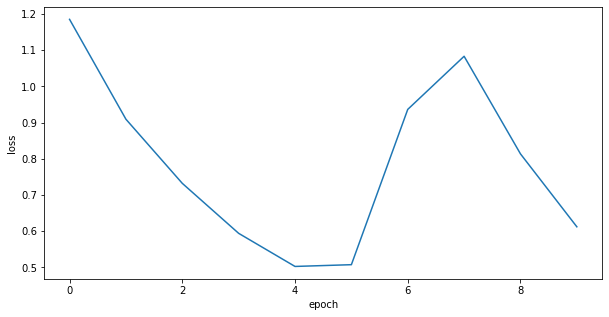

In [447]:
plt.figure(figsize=(10,5))
plt.plot(history_train)
plt.plot(history_eval)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./figure/key_word.png')
plt.show()

In [276]:
Path = "./saved_Erato_noisel"
torch.save(Erato_model, Path)

In [575]:
Path = 'saved_Erato_keyword_final'
Erato_model = torch.load(Path)

In [438]:
def predict_greedy(model, sentence, max_length=100):
    """Make predictions for the given input using greedy inference.
    
    Args:
        model: A sequence-to-sequence model.
        sentence: A input string.
        max_length: The maximum length at which to truncate outputs in order to
            avoid non-terminating inference.
    
    Returns:
        Model's predicted greedy response for the input, represented as string.
    """

    # You should make only one call to model.encode() at the start of the function, 
    # and make only one call to model.decode() per inference step.
    model.eval()    
    src_id = torch.tensor(vocab.get_ids_from_sentence(sentence))[:,None].to(device)
    encoder_output, encoder_mask, last_hidden = model.encode(src_id) 
    input = src_id[0,:]
    out = [bos_id]
    for t in range(max_length):
        input = input[None,:]
        out_decoder, last_hidden, _ = model.decode(input, last_hidden, encoder_output, encoder_mask)
        input = out_decoder.argmax(dim=-1)
        word = input.item()
        out.append(word)
        if word == eos_id:
            break
    
    decoded = vocab.decode_sentence_from_ids(out)
    return decoded
    

In [439]:
def predict_beam(model, sentence, k=5, max_length=100, hidden = None):

    alpha = 0.3
    model.eval()
    
    sentence_ids = torch.tensor(vocab.get_ids_from_sentence(sentence)).cuda()
    sentence_ids = sentence_ids.unsqueeze(1)
    encoder_output, encoder_mask, h = model.encode(sentence_ids)

    out_start = sentence_ids[0]
    beam = [out_start for i in range(k)]
    beam_scores = [1 for i in range(k)]
    
    if hidden:
        h = hidden
    hiddens = [h for i in range(k)]
    
    generations = []
    generations_scores = []
    curr_l = 0
    eos_tensor = torch.Tensor([eos_id]).int().cuda()
    while beam:
        logits = torch.Tensor().cuda()
        inds = torch.Tensor().int().cuda()
        curr_k = len(beam)
        if curr_l==max_length:
            for i in range(curr_k):
                  generations += [torch.cat((beam[i],eos_tensor),0)]
                  generations_scores += [new_beam_scores[i]]
            break
        else:
            for i in range(curr_k):
                out, hiddens[i], _ = model.decode(beam[i][-1].view(1,1), hiddens[i], encoder_output,
                                     encoder_mask)
                logit,ind = torch.topk(out.squeeze(), curr_k, dim=0)
                logits = torch.cat((logits,logit),0)
                inds = torch.cat((inds,ind),0)
            new_beam = []
            new_beam_scores = []
            new_hiddens = []
            if curr_l==0:
                for i in range(curr_k):
                    max_ind = torch.argmax(nn.functional.log_softmax(logit,dim=0))
                    new_beam_scores += [float(logit[max_ind])]
                    logit[max_ind] = -1e9
                    new_beam += [torch.cat((beam[0],ind[max_ind].unsqueeze(0)),0)]
                    new_hiddens += [hiddens[0]]
            else:
                top_logits,top_inds_logit = torch.topk(torch.repeat_interleave(torch.Tensor(beam_scores).cuda(),
                                                                               curr_k)\
                                                       +nn.functional.log_softmax(logits,dim=0),
                                                       curr_k, dim=0)
                for i in range(curr_k):
                    if inds[top_inds_logit[i]]==eos_id:
                        generations += [torch.cat((beam[top_inds_logit[i]//curr_k],inds[top_inds_logit[i]].unsqueeze(0)),0)]
                        generations_scores+=[float(logits[top_inds_logit[i]])/(generations[-1].shape[0]**alpha)]
                    else:
                        new_beam += [torch.cat((beam[top_inds_logit[i]//curr_k],inds[top_inds_logit[i]].unsqueeze(0)),0)]
                        new_hiddens += [hiddens[top_inds_logit[i]//curr_k]]
                        new_beam_scores += [float(logits[top_inds_logit[i]])]
            beam = new_beam
            beam_scores = new_beam_scores
            hiddens = new_hiddens
        curr_l +=1
    generations = [g for _, g in sorted(zip(generations_scores, generations))]
    generations.reverse()
    sorted_scores = sorted(generations_scores)
    sorted_scores.reverse()
    return [vocab.decode_sentence_from_ids(s.tolist()) for s in generations], sorted_scores

In [533]:

author = "WILLIAM SHAKESPEARE"
key_words = ['king', 'joy', 'day']

sentence = author.lower() + ' sep ' + ' '.join(key_words)

print(predict_greedy(Erato_model, sentence, max_length=100))
print()
b, s = predict_beam(Erato_model, sentence, k=30, max_length=100)


b

i joy to the day of night



['though i have seen the hungry divine of day ?',
 'this day the herald of loves mighty king',
 'that day the herald of loves mighty king',
 'this day the herald of such day !',
 'this day the herald of love to sullied night',
 'save thou the king of such day !',
 'though i have seen th day of night ?',
 'though i have seen the hungry of day .',
 'this day the herald of loves mighty king !',
 'this day the herald of the day !',
 'though i have seen the hungry of day ?',
 'though i have seen the hungry divine of day',
 'though i have seen th day of day ?',
 'though i have seen the day of day ?',
 'this day the herald of such day',
 'that day the herald of such day',
 'i joy to the new day of day',
 'though i have seen the day of day',
 'save thou the king of such day',
 'though i have seen the hungry of day',
 'though i have seen th day of day shapes',
 'though i have seen th day of day',
 'this day the herald of the day',
 'that day the herald of the day',
 'save thou the king of the d

In [470]:
def generate_peom(model, author, key_words, method = "greedy", context_type = "key_word", k_beam = 10, nb_line = 5):
    out = []
    inp_sentence = author + " sep " +  ' '.join(key_words)
    print(author + " <sep> " +  ' '.join(key_words))
    print()
    for nb in range(nb_line):
        if method == "greedy":
            sent_out = predict_greedy(model, inp_sentence, max_length=100)
            out.append(sent_out)
            rand_words = np.random.choice(sent_out.split(),2)
            if context_type == "key_word":
                inp_sentence = author + " sep " + ' '.join(key_words) + ' '.join(rand_words)
            else:
                inp_sentence = author + " sep " + sent_out
            
        else:
            sent_out_beam, scores = predict_beam(model, inp_sentence, k=k_beam, max_length=100)
            sent_out = sent_out_beam[0]
            scores = np.array(scores)/sum(scores)
            sent_out = np.random.choice(sent_out_beam, p = scores)
            out.append(sent_out)
            rand_words = np.random.choice(sent_out.split(),2)
            if context_type == "key_word":
                inp_sentence = author + " sep " + ' '.join(key_words) + ' '.join(rand_words)
            else:
                inp_sentence = author + " sep " + sent_out
    return out

In [583]:
key_words = ['cry', 'darkness']

author = "D. H. LAWRENCE "
author = "WILLIAM BUTLER YEATS "


author = "JOHN DONNE "


author = "JOHN DONNE "



author = "D. H. LAWRENCE "

author = "EDMUND SPENSER"
author = "WILLIAM SHAKESPEARE"
method = "beam"

context_type = "key_word"
k_beam = 30
nb_line = 10

poem = generate_peom(Erato_model, author, key_words, method = method, context_type = context_type, k_beam = k_beam, nb_line = nb_line)


print(',\n'.join(poem))
evaluate_diversity(poem)

WILLIAM SHAKESPEARE <sep> cry darkness

tir cry upon my life .,
lest thy scorn cry to my pain .,
w en thy father to my birth s go,
whilst though my ladies cry my heart,
whilst though my father s heart to speak,
waken thy father s mine to serve you delight ? .,
upon a thousand victories love s born fled . . .,
when to my sight unto a green cry,
whilst when my thoughts bowed still unto my cry . . .,
tir d with her cry nor cry aloud cry .


(38.1, 0.5111111111111111, 0.875)

# Automatic Evaluation

In [ ]:
def mean(lst):
    return sum(lst) / len(lst)


In [568]:
Path = 'saved_Erato_keyword_final'
model = torch.load(Path)

author = "WILLIAM SHAKESPEARE"
method = "beam"
context_type = "key_word"
key_words = ['king', 'joy', 'day']
k_beam = 30
nb_line = 5
nb_poem = 10


x = range(5,70,5)
res_avr = []
res_uni = []
res_bi = []
for k_beam in x:
    l_avr = []
    l_uni = []
    l_bi = []
    for k in range(nb_poem):
        poem = generate_peom(Erato_model, author, key_words, method = method, context_type = context_type, k_beam = k_beam, nb_line = 5)
        avr, uni, bi = evaluate_diversity(poem)
        l_avr.append(avr)
        l_uni.append(uni)
        l_bi.append(bi)
        
    res_avr.append(mean(l_avr))
    res_uni.append(mean(l_uni))
    res_bi.append(mean(l_bi))
    

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day

WILLIAM SHAKESPEARE <sep> king joy day



In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_train)
plt.plot(history_eval)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./figure/key_word.png')
plt.show()

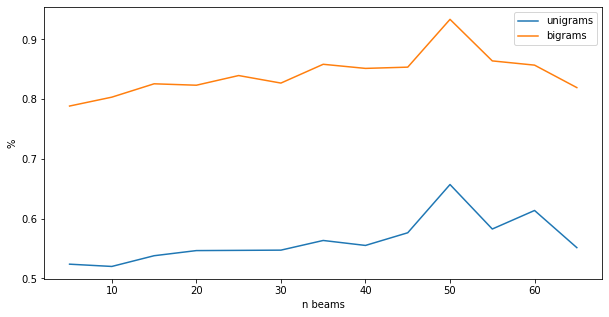

In [569]:
plt.figure(figsize=(10,5))
plt.plot(x,res_uni, label = 'unigrams')
plt.plot(x,res_bi, label = 'bigrams')
plt.xlabel('n beams')
plt.ylabel('%')
plt.legend()
plt.savefig('./figure/k_beams2.png')
plt.show()